##### Import

In [1]:
import os
import sys
import warnings
import gc
from pathlib import Path

import papermill as pm
import scrapbook as sb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from tqdm import tqdm
import shap

# Filter out warning messages
warnings.filterwarnings('ignore')

# Set pandas display options
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

# Set seaborn style
sns.set_style('whitegrid')

# Add the parent directory to sys.path
sys.path.insert(1, os.path.join(sys.path[0], '..'))

# Index and deciles for data slicing
idx = pd.IndexSlice

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


#### Test on unseen data

In [2]:
from pathlib import Path
import pandas as pd
import lightgbm as lgb
from utils import rank_stocks_and_quantile
import pickle

def load_model_and_parameters(path):
    with open(path, 'rb') as file:
        loaded_object = pickle.load(file)
    return loaded_object['model'], loaded_object['params']


def read_and_process_data(store_path, key, target_substring):
    with pd.HDFStore(store_path) as store:
        data = store[key]
    data = rank_stocks_and_quantile(data, target_substring=target_substring)
    # data.index.set_levels(data.index.levels[0].tz_localize(None), level=0, inplace=True)
    new_index = data.index.set_levels(data.index.levels[0].tz_localize(None), level=0)
    data.set_index(new_index, inplace=True)

    return data


# def filter_by_date(data, look_ahead):
#     unique_dates = data.index.get_level_values('date').unique().sort_values()
#     cut_off_date = unique_dates[0] - pd.Timedelta(days=look_ahead)
#     return data[data.index.get_level_values('date') > cut_off_date]

def filter_by_date(data, look_ahead):
    unique_dates = data.index.get_level_values('date').unique().sort_values()
    
    # Ensure that there are enough unique dates for the look_ahead value
    assert len(unique_dates) > look_ahead, f"Insufficient unique dates for a look_ahead value of {look_ahead}"
    
    cut_off_date = unique_dates[look_ahead]
    
    return data[data.index.get_level_values('date') > cut_off_date]


def synchronize_and_merge_predictions(data, features, model, label):
    y_pred = model.predict(data[features])
    synchronized_labels = data[label][data[label].index.isin(data[features].index)]
    synchronized_y_pred = y_pred[:len(synchronized_labels)]

    preds = synchronized_labels.reset_index(name='actual').assign(predicted=\
        synchronized_y_pred).set_index(['date', 'ticker'])

    # Renaming and merging
    cols_to_rename = ['open', 'high', 'low', 'close', 'volume']
    new_col_names = ["FEATURE_" + col for col in cols_to_rename]
    rename_dict = dict(zip(cols_to_rename, new_col_names))

    data_renamed = data.rename(columns=rename_dict)
    preds = preds.reset_index().merge(data_renamed[new_col_names].reset_index(), \
        on=['ticker', 'date'], how='left')
    return preds[['date', 'ticker', 'actual', 'predicted'] \
        + new_col_names].set_index(['ticker', 'date'])


# Constants and Initial Setup
TOP = 250
UNSEEN_KEY = '/data/YEAR_20220803_20230803'
UNSEEN_STORE = Path(f'data/{TOP}_unseen_dataset.h5')
MODEL_PATH = "/home/sayem/Desktop/Project/models/250_combined_model_and_params_TARGET_ret_fwd_01d_rank_quantiled.pkl"

# Main Execution
best_model, params = load_model_and_parameters(MODEL_PATH)
test_data = read_and_process_data(UNSEEN_STORE, UNSEEN_KEY, 'TARGET_ret_fwd_')
filtered_test_data = filter_by_date(test_data, params.get('look_ahead', 1))
label = f'TARGET_ret_fwd_{params.get("look_ahead", 1):02d}d_rank_quantiled'
features = [col for col in test_data.columns if col.startswith('FEATURE_')]
preds = synchronize_and_merge_predictions(filtered_test_data, features, best_model, label)

preds.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 65484 entries, ('AA', Timestamp('2022-08-05 00:00:00')) to ('ZTS', Timestamp('2023-08-03 00:00:00'))
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   actual          65484 non-null  float64
 1   predicted       65484 non-null  float64
 2   FEATURE_open    65484 non-null  float32
 3   FEATURE_high    65484 non-null  float32
 4   FEATURE_low     65484 non-null  float32
 5   FEATURE_close   65484 non-null  float32
 6   FEATURE_volume  65484 non-null  float64
dtypes: float32(4), float64(3)
memory usage: 2.8+ MB


In [3]:
# Assuming your DataFrame is named `df`
df = preds.swaplevel(0, 1).sort_index()
print(df.info())


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 65484 entries, (Timestamp('2022-08-05 00:00:00'), 'AA') to (Timestamp('2023-08-03 00:00:00'), 'ZTS')
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   actual          65484 non-null  float64
 1   predicted       65484 non-null  float64
 2   FEATURE_open    65484 non-null  float32
 3   FEATURE_high    65484 non-null  float32
 4   FEATURE_low     65484 non-null  float32
 5   FEATURE_close   65484 non-null  float32
 6   FEATURE_volume  65484 non-null  float64
dtypes: float32(4), float64(3)
memory usage: 2.8+ MB
None


In [4]:
df

actual  predicted  FEATURE_open  FEATURE_high  FEATURE_low  \
date       ticker                                                               
2022-08-05 AA        0.00   0.500066     47.274101     51.116501    47.234299   
           AAL       1.00   0.497752     14.620000     14.980000    14.610000   
           AAPL      0.25   0.502840    162.940002    165.574997   162.729996   
           ABBV      1.00   0.502349    137.649002    138.501007   136.559998   
           ABT       0.25   0.500898    108.238998    108.802002   107.880997   
...                   ...        ...           ...           ...          ...   
2023-08-03 WYNN      0.00   0.499583    104.250000    106.849998   102.129997   
           X         0.50   0.499625     24.360001     24.865000    23.750000   
           XOM       0.75   0.500782    105.889999    107.879997   105.300003   
           YUM       0.25   0.499725    134.410004    136.259995   133.470001   
           ZTS       0.25   0.500444    180.610001    183.259995   179.759995   

                   FEATURE_close  FEATURE_volume  
date       ticker                                 
2022-08-05 AA          49.294899    5.097970e+06  
           AAL         14.740000    1.950384e+07  
           AAPL       165.076004    5.679104e+07  
           ABBV       136.649994    5.425790e+06  
           ABT        108.737000    2.802808e+06  
...                          ...             ...  
2023-08-03 WYNN       105.610001    1.614293e+06  
           X           24.260000    9.083687e+06  
           XOM        107.120003    1.628311e+07  
           YUM        135.619995    2.392271e+06  
           ZTS        180.880005    1.688031e+06  

[65484 rows x 7 columns]

In [5]:
def daily_spearman(group):
    return spearmanr(group['actual'], group['predicted'])[0]

daily_correlations = preds.groupby('date').apply(daily_spearman)

In [6]:
from scipy.stats import spearmanr

def calculate_daily_spearman_correlation(group):
    """Calculate the daily Spearman correlation between actual and predicted values."""
    return spearmanr(group['actual'], group['predicted'])[0]

# Compute the daily Spearman correlation for each date
spearman_correlations_daily = preds.groupby('date').apply(calculate_daily_spearman_correlation)

# Calculate the average Spearman correlation over all dates
average_spearman_correlation = spearman_correlations_daily.mean()

# Calculate the Sharpe ratio for each date
daily_sharpe_ratios = spearman_correlations_daily / spearman_correlations_daily.std()

# Convert the Sharpe ratios to a DataFrame
sharpe_ratios_dataframe = daily_sharpe_ratios.to_frame()
sharpe_ratios_dataframe.columns = sharpe_ratios_dataframe.columns.astype(str)
sb.glue("sharpe_ratios_per_day", sharpe_ratios_dataframe, display=False)

In [7]:
# import matplotlib.pyplot as plt

# # Create a list of colors based on the sign of the Sharpe Ratios
# colors = ['blue' if value > 0 else 'red' for value in daily_sharpe_ratios]

# plt.figure(figsize=(12,6))
# daily_sharpe_ratios.plot(kind='bar', color=colors)
# plt.title('Daily Sharpe Ratios')
# plt.xlabel('Date')
# plt.ylabel('Sharpe Ratio')
# plt.grid(axis='y')
# plt.tight_layout()
# plt.axhline(y=0, color='black', linestyle='-')  # Add a horizontal line at y=0
# plt.xticks(rotation=45)  # Rotate the x-axis labels for better visibility
# plt.show()

In [8]:
lr_r, lr_p = spearmanr(preds.actual, preds.predicted)
print(f'Information Coefficient (overall): {lr_r:.3%} (p-value: {lr_p:.8%})')

# Return the Information Coefficient and its p-value
information_coefficient = lr_r
p_value = lr_p

# information_coefficient = papermill_information_coefficient, p_value = papermill_p_value
sb.glue("information_coefficient", information_coefficient, display=True)
sb.glue("p_value", p_value, display=True)

Information Coefficient (overall): 3.527% (p-value: 0.00000000%)


0.03526564270234501

1.7634964752765114e-19

In [9]:
preds.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 65484 entries, ('AA', Timestamp('2022-08-05 00:00:00')) to ('ZTS', Timestamp('2023-08-03 00:00:00'))
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   actual          65484 non-null  float64
 1   predicted       65484 non-null  float64
 2   FEATURE_open    65484 non-null  float32
 3   FEATURE_high    65484 non-null  float32
 4   FEATURE_low     65484 non-null  float32
 5   FEATURE_close   65484 non-null  float32
 6   FEATURE_volume  65484 non-null  float64
dtypes: float32(4), float64(3)
memory usage: 2.8+ MB


In [10]:
def add_quantile_signals(df, col_name='predicted', buy_threshold=0.8, sell_threshold=0.1):
    buy_cutoff = df[col_name].quantile(buy_threshold)
    sell_cutoff = df[col_name].quantile(sell_threshold)
    
    # Create a new column for signals
    df['signal'] = 0  # Neutral by default
    df.loc[df[col_name] >= buy_cutoff, 'signal'] = 1  # Buy
    df.loc[df[col_name] <= sell_cutoff, 'signal'] = -1  # Sell
    return df

# Apply the function ## Testing
preds = add_quantile_signals(preds.copy(), buy_threshold=0.95, sell_threshold=0.05)

In [11]:
preds.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 65484 entries, ('AA', Timestamp('2022-08-05 00:00:00')) to ('ZTS', Timestamp('2023-08-03 00:00:00'))
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   actual          65484 non-null  float64
 1   predicted       65484 non-null  float64
 2   FEATURE_open    65484 non-null  float32
 3   FEATURE_high    65484 non-null  float32
 4   FEATURE_low     65484 non-null  float32
 5   FEATURE_close   65484 non-null  float32
 6   FEATURE_volume  65484 non-null  float64
 7   signal          65484 non-null  int64  
dtypes: float32(4), float64(3), int64(1)
memory usage: 3.3+ MB


##### Backtesting

In [15]:
import pandas as pd
import backtrader as bt
import backtrader.indicators as btind
import backtrader.analyzers as btanalyzers
from pypfopt import EfficientFrontier, expected_returns, risk_models
import yfinance as yf

# Data Class for Predictions
class PandasPredictions(bt.feeds.PandasData):
    lines = ('signal',)
    params = (
        ('signal', -1),
        ('open', 'FEATURE_open'),
        ('high', 'FEATURE_high'),
        ('low', 'FEATURE_low'),
        ('close', 'FEATURE_close'),
        ('volume', 'FEATURE_volume')
    )

# Function to optimize weights using PyPortfolioOpt
def optimize_weights(datas):
    prices = {}
    for data in datas:
        s = pd.Series(data.close.array, index=data.datetime.array, name=data._name)
        s = s.groupby(s.index).first()  # This will drop duplicate datetime entries, if any
        prices[data._name] = s
    df = pd.concat(prices, axis=1).dropna()

    mu = expected_returns.mean_historical_return(df)
    S_original = risk_models.sample_cov(df)
    S = (1 - 0.05) * S_original + 0.05 * np.eye(S_original.shape[0])
    S += 1e-6 * np.eye(S_original.shape[0])
    
    ef = EfficientFrontier(mu, S, solver="SCS", verbose=True)
    try:
        weights = ef.max_sharpe(risk_free_rate=0.005)
    except ValueError as e:
        if "expected return exceeding the risk-free rate" in str(e):
            print("Using alternative method due to low expected returns.")
            weights = ef.min_volatility()  # or any other method you'd prefer
        else:
            raise e
    # weights = ef.max_sharpe(risk_free_rate=0.005)
    return weights

# Strategy Class
class TradeAndRebalanceStrategy(bt.Strategy):    
    params = {'stop_loss': 0.05, 'take_profit': 0.10}
    
    def __init__(self):
        self.rebalance_days = 0
        self.max_loss = -0.15
        self.start_cash = self.broker.get_cash()
        self.orders = {}  
        self.atr_dict = {data: btind.ATR(data) for data in self.datas}

    def notify_order(self, order):
        if order.status == order.Completed and order.ref in self.orders:
            del self.orders[order.ref]

    def next(self):        
        for data in self.datas:
            atr_value = self.atr_dict.get(data, 0)[0]
            if data.signal[0] == 1:
                order = self.buy(data)
                self.orders[order.ref] = order
                stop_price = data.close[0] - atr_value * 2
                limit_price = data.close[0] + atr_value * 2
                self.sell(data=data, exectype=bt.Order.Stop, price=stop_price, parent=order.ref)
                self.sell(data=data, exectype=bt.Order.Limit, price=limit_price, parent=order.ref)
            elif data.signal[0] == -1:
                self.sell(data)

        if not self.rebalance_days:
            weights = optimize_weights(self.datas)
            weights = {k: min(v, 0.30) for k, v in weights.items()}
            for data in self.datas:
                self.order_target_percent(data, target=weights.get(data._name, 0))
            self.rebalance_days = 20
        else:
            self.rebalance_days -= 1

# Setup
cerebro = bt.Cerebro()
cerebro.broker.setcommission(commission=0.001)
cerebro.addanalyzer(btanalyzers.PyFolio, _name='pyfolio')

data_dict = {ticker: preds.xs(ticker) for ticker in preds.index.get_level_values(0).unique()}
for ticker, data_df in data_dict.items():
    data = PandasPredictions(dataname=data_df, name=ticker)
    cerebro.adddata(data)

cerebro.addstrategy(TradeAndRebalanceStrategy)
results = cerebro.run()

# Performance Analysis
returns, positions, transactions, gross_lev = results[0].analyzers.pyfolio.get_pf_items()

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Oct 04 11:57:52 PM: Your problem has 251 variables, 5 constraints, and 0 parameters.
(CVXPY) Oct 04 11:57:52 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 04 11:57:52 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 04 11:57:52 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 04 11:57:52 PM: Compiling problem (target solver=SCS).
(CVXPY) Oct 04 11:57:52 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing ->

                           Strategy
-------------------------  ----------
Start Period               2022-08-05
End Period                 2022-09-29
Risk-Free Rate             0.0%
Time in Market             62.0%

Cumulative Return          206.3%
CAGR﹪                     16781.87%

Sharpe                     10.65
Prob. Sharpe Ratio         100.0%
Smart Sharpe               9.77
Sortino                    78.73
Smart Sortino              72.26
Sortino/√2                 55.67
Smart Sortino/√2           51.09
Omega                      18.16

Max Drawdown               -2.58%
Longest DD Days            1
Volatility (ann.)          71.09%
Calmar                     6513.54
Skew                       1.23
Kurtosis                   0.83

Expected Daily %           2.91%
Expected Monthly %         75.01%
Expected Yearly %          206.3%
Kelly Criterion            78.74%
Risk of Ruin               0.0%
Daily Value-at-Risk        -4.36%
Expected Shortfall (cVaR)  -4.36%

Max Consecutive

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-09-02,2022-09-02,2022-09-02,1,-2.576460,NaN
2,2022-09-27,2022-09-27,2022-09-27,1,-2.319993,NaN
3,2022-08-30,2022-08-30,2022-08-30,1,-1.423052,NaN
4,2022-09-21,2022-09-21,2022-09-21,1,-0.508683,NaN


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


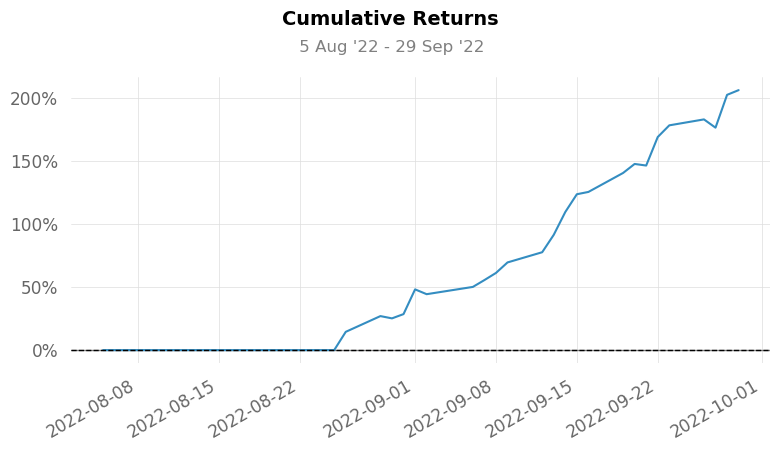

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


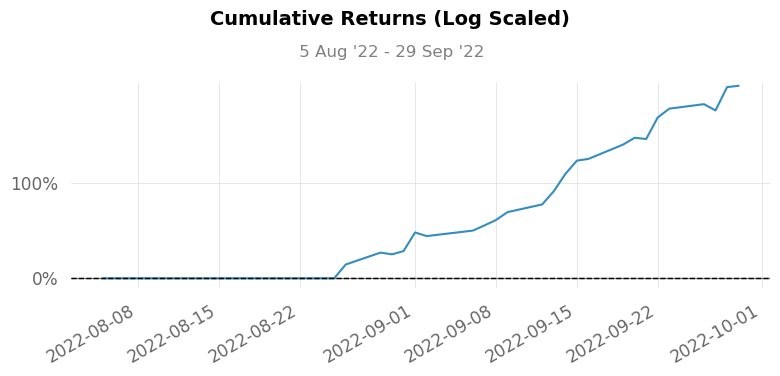

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


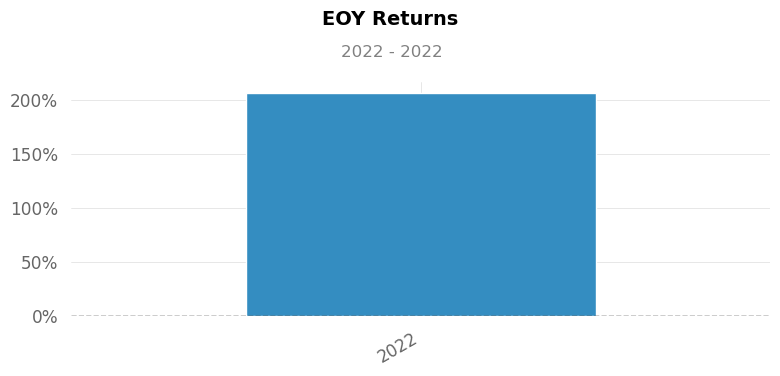

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


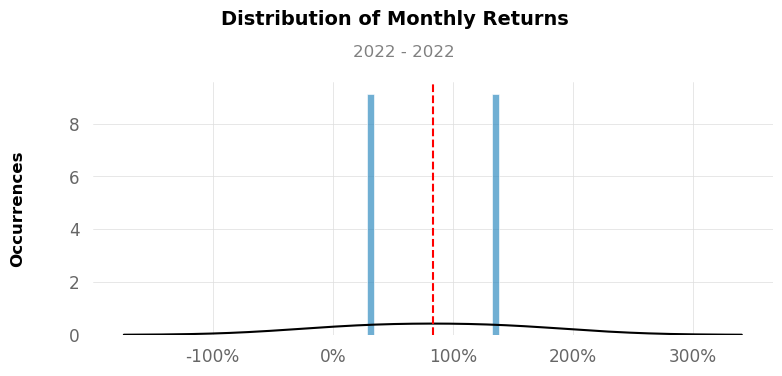

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


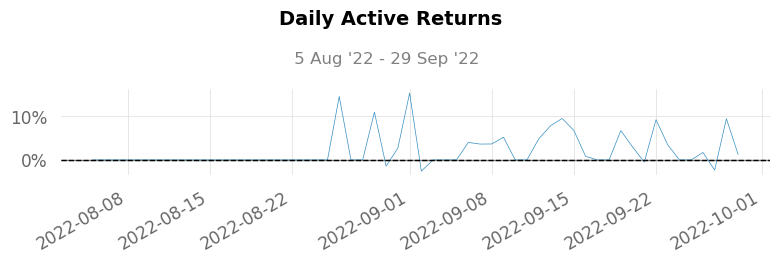

IndexError: index 0 is out of bounds for axis 0 with size 0

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


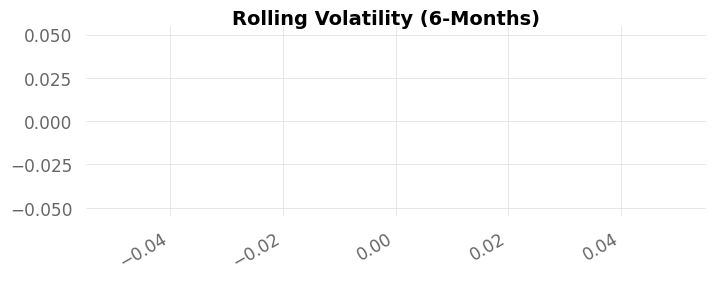

In [19]:
import quantstats as qs
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")


# Extend the Quantstats reports to consider the entire dataframe
qs.extend_pandas()

# # # # # # Print extended, in-depth performance stats
# qs.reports.full(returns)

# # Plotting various graphs
# qs.plots.snapshot(returns, title='Performance Snapshot')  # Snapshot of the performance
# qs.plots.monthly_heatmap(returns)  # Monthly returns heatmap
# qs.plots.yearly_returns(returns)   # Yearly returns
# plt.show()
# print(f"top: {top} target: {target}")

# Print only the metrics
qs.reports.metrics(returns)

In [17]:
# ### SP500 dependency
# import pandas as pd
# import backtrader as bt
# import backtrader.indicators as btind  # <-- NEW: For adding indicators
# import backtrader.analyzers as btanalyzers
# from pypfopt import EfficientFrontier, expected_returns, risk_models
# import yfinance as yf

# # Data Class for Predictions
# class PandasPredictions(bt.feeds.PandasData):
#     lines = ('signal',)
#     params = (
#         ('signal', -1),
#         ('open', 'FEATURE_open'),
#         ('high', 'FEATURE_high'),
#         ('low', 'FEATURE_low'),
#         ('close', 'FEATURE_close'),
#         ('volume', 'FEATURE_volume')
#     )

# # # Function to optimize weights using PyPortfolioOpt
# def optimize_weights(datas):
#     prices = {}
    
#     for data in datas:
#         s = pd.Series(data.close.array, index=data.datetime.array, name=data._name)
#         prices[data._name] = s

#     df = pd.DataFrame(index=prices[next(iter(prices))].index)

#     for ticker, s in prices.items():
#         df = df.merge(s, left_index=True, right_index=True, \
#             how='left').rename(columns={s.name: ticker})

#     df = df.dropna()

#     mu = expected_returns.mean_historical_return(df)
    
#     S_original = risk_models.sample_cov(df)
    
#     # Regularize the covariance matrix
#     delta = 0.05
#     S = (1 - delta) * S_original + delta * np.eye(S_original.shape[0])
    
#     # Ensure diagonal elements are strictly positive
#     S = S + 1e-6 * np.eye(S_original.shape[0])
    
#     ef = EfficientFrontier(mu, S, solver="SCS", verbose=True)
#     weights = ef.max_sharpe(risk_free_rate=0.005)
#     return ef.clean_weights()


# # Strategy Class
# class TradeAndRebalanceStrategy(bt.Strategy):
#     lines = ('benchmark',)
    
#     params = (
#         ('stop_loss', 0.05),
#         ('take_profit', 0.10),
#         ('benchmark_MA_period', 21)  # <-- NEW: Moving Average period for the benchmark
#     )
    
#     def __init__(self):
#         self.rebalance_days = 0
#         self.max_loss = -0.15
#         self.start_cash = self.broker.get_cash()
#         self.benchmark_data = self.getdatabyname("S&P 500")
#         self.benchmark_MA = btind.SimpleMovingAverage(self.benchmark_data, \
#             period=self.params.benchmark_MA_period)
#         self.orders = {}  # to store buy order references
#         self.atr_dict = {data: btind.ATR(data, period=14) for data in self.datas if data._name != "S&P 500"}


#     def log(self, txt, dt=None):
#         ''' Logging function for the strategy. It logs the date and the message provided. '''
#         dt = dt or self.datas[0].datetime.date(0)
#         print(f"{dt.isoformat()}, {txt}")

#     def notify_order(self, order):
#         # If an order is completed, remove it from the orders dict
#         if order.status == order.Completed:
#             if order.ref in self.orders:
#                 del self.orders[order.ref]

#     def next(self):
#         # Use the moving average of the benchmark for decisions
#         if self.benchmark_data.close[0] > self.benchmark_MA[0] * 1.01:  # Bullish scenario
#             benchmark_trend = 1
#         else:  # Bearish scenario
#             benchmark_trend = -1
            
#         self.log(f"Benchmark Trend: {'Bullish' if benchmark_trend == 1 else 'Bearish'}")

#         benchmark_return = (self.benchmark_data.close[0] - \
#             self.benchmark_data.close[-1]) / self.benchmark_data.close[-1]
#         self.log(f"Benchmark Return: {benchmark_return * 100:.2f}%")

#         if (self.broker.get_cash() - self.start_cash) / self.start_cash <= self.max_loss:
#             return
        
#         for data in self.datas:
#             if data._name == "S&P 500":  # Skip the benchmark for trading signals
#                 continue
#             atr_value = self.atr_dict[data][0] if data in self.atr_dict else 0

#             # Making decisions based on benchmark's performance
#             if benchmark_return > 0:  # Benchmark shows positive returns
#                 if data.signal[0] == 1:
#                     order = self.buy(data)
#                     self.orders[order.ref] = order
                    
#                     # Setting dynamic stop-loss and take-profit levels using ATR
#                     stop_price = data.close[0] - atr_value * 2  # Using 2 times ATR as stop loss
#                     limit_price = data.close[0] + atr_value * 2  # Using 2 times ATR as take profit
                    
#                     self.sell(data=data, exectype=bt.Order.Stop, price=stop_price, parent=order.ref)
#                     self.sell(data=data, exectype=bt.Order.Limit, price=limit_price, parent=order.ref)
                    
#             elif benchmark_return < 0:  # Benchmark shows negative returns
#                 self.sell(data)

#         if self.rebalance_days == 0:
#             weights = optimize_weights([data for data in self.datas if data._name != "S&P 500"])
#             for asset, weight in weights.items():
#                 if weight > 0.30:
#                     weights[asset] = 0.30
            
#             for data in self.datas:
#                 if data._name == "S&P 500":
#                     continue
#                 if data._name in weights:
#                     self.order_target_percent(data, target=weights[data._name])
#                 else:
#                     self.close(data)
#             self.rebalance_days = 20
#         else:
#             self.rebalance_days -= 1


# # Fetch S&P 500 data using yfinance
# def fetch_data(ticker, start_date, end_date):
#     df = yf.download(ticker, start=start_date, end=end_date)
#     return df

# # Assume preds is defined somewhere earlier in your code
# start_date = preds.index.get_level_values(1).min()
# end_date = preds.index.get_level_values(1).max()
# sp500_data = fetch_data('^GSPC', start_date, end_date)

# # Convert it into Backtrader format
# benchmark = bt.feeds.PandasData(dataname=sp500_data, name="S&P 500")

# cerebro = bt.Cerebro()
# cerebro.broker.setcommission(commission=0.001)
# cerebro.addanalyzer(btanalyzers.PyFolio, _name='pyfolio')
# cerebro.adddata(benchmark)

# data_dict = {ticker: preds.xs(ticker) for ticker in preds.index.get_level_values(0).unique()}
# for ticker, data_df in data_dict.items():
#     data = PandasPredictions(dataname=data_df, name=ticker)
#     cerebro.adddata(data)

# cerebro.addstrategy(TradeAndRebalanceStrategy)
# results = cerebro.run()

# # Performance Analysis
# returns, positions, transactions, gross_lev \
#     = results[0].analyzers.pyfolio.get_pf_items()

In [18]:
import quantstats as qs
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")


# Extend the Quantstats reports to consider the entire dataframe
qs.extend_pandas()

# # # # # Print extended, in-depth performance stats
# qs.reports.full(returns)

# # Plotting various graphs
# qs.plots.snapshot(returns, title='Performance Snapshot')  # Snapshot of the performance
# qs.plots.monthly_heatmap(returns)  # Monthly returns heatmap
# qs.plots.yearly_returns(returns)   # Yearly returns
# plt.show()
# print(f"top: {top} target: {target}")

# Print only the metrics
qs.reports.metrics(returns)

                    Strategy
------------------  ----------
Start Period        2022-08-05
End Period          2022-09-29
Risk-Free Rate      0.0%
Time in Market      62.0%

Cumulative Return   206.3%
CAGR﹪              16781.87%

Sharpe              10.65
Prob. Sharpe Ratio  100.0%
Sortino             78.73
Sortino/√2          55.67
Omega               18.16

Max Drawdown        -2.58%
Longest DD Days     1

Gain/Pain Ratio     17.16
Gain/Pain (1M)      -

Payoff Ratio        3.63
Profit Factor       18.16
Common Sense Ratio  135.22
CPC Index           54.94
Tail Ratio          7.45
Outlier Win Ratio   4.23
Outlier Loss Ratio  1.45

MTD                 138.26%
3M                  206.3%
6M                  206.3%
YTD                 206.3%
1Y                  206.3%
3Y (ann.)           16781.87%
5Y (ann.)           16781.87%
10Y (ann.)          16781.87%
All-time (ann.)     16781.87%

Avg. Drawdown       -1.71%
Avg. Drawdown Days  1
Recovery Factor     45.47
Ulcer Index         0.01
S